## Imports

In [1]:
import numpy as np
import cv2
from skimage.feature import hog

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.svm import LinearSVC
from sklearn import svm, datasets

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import glob
import random

%matplotlib inline

## Constants

In [2]:
PATH_TEST_IMAGES = 'test_images/'
PATH_VEHICLE_IMAGES = 'train_test_data/vehicles/'
PATH_NON_VEHICLE_IMAGES = 'train_test_data/non-vehicles/'

YSTART = 400
YSTOP = 656

SPATIAL_BIN = 16
HIST_BINS= 64
ORIENT = 6
PIX_PER_CELLS = 8
CELL_PER_BLOCK = 2
SCALE = 1.5

## 1. Histogram of Oriented Gradients (HOG)

In [3]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [4]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace, spatial_size, 
                        hist_bins,orient, pix_per_cell, cell_per_block):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        #HOG
        ch1 = feature_image[:,:,0]
        ch2 = feature_image[:,:,1]
        ch3 = feature_image[:,:,2]

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
        hog_feat1 = hog1.ravel() 
        hog_feat2 = hog2.ravel() 
        hog_feat3 = hog3.ravel() 
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

        # Scale features and make a prediction
        #features = np.hstack((spatial_features, hist_features, hog_features)) 

        # Append the new feature vector to the features list
        features.append(np.hstack((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

In [5]:
#*********************Original**************************
# # Define a function to extract features from a list of images
# # Have this function call bin_spatial() and color_hist()
# def extract_features(imgs, cspace='RGB', spatial_size=(32, 32),
#                         hist_bins=32):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for file in imgs:
#         # Read in each one by one
#         image = mpimg.imread(file)
#         # apply color conversion if other than 'RGB'
#         if cspace != 'RGB':
#             if cspace == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif cspace == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif cspace == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif cspace == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif cspace == 'YCrCb':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
#         else: feature_image = np.copy(image)      
#         # Apply bin_spatial() to get spatial color features
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         # Apply color_hist() also with a color space option now
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         # Append the new feature vector to the features list
#         features.append(np.concatenate((spatial_features, hist_features)))
#     # Return list of feature vectors
#     return features

In [6]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
             
            #test_prediction = svc.predict(test_features)

#             if test_prediction == 1:
#                 xbox_left = np.int(xleft*scale)
#                 ytop_draw = np.int(ytop*scale)
#                 win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

    return draw_img

In [7]:
def read_image(filename):
    image = mpimg.imread(PATH_TEST_IMAGES+filename)
    return image
    
def crop_vertical(image):
    #vertical_center = (int)(image.shape[0]/2)
    return image[YSTART:YSTOP]

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def init_image(filename):
    #Read image
    image = read_image(filename)
    #Crop the vertical upper half. Cars can only be in the lower half of the image
    image = crop_vertical(image)
    #Convert to grayscale
    image = grayscale(image)
    
    return image

## HOG - Tests

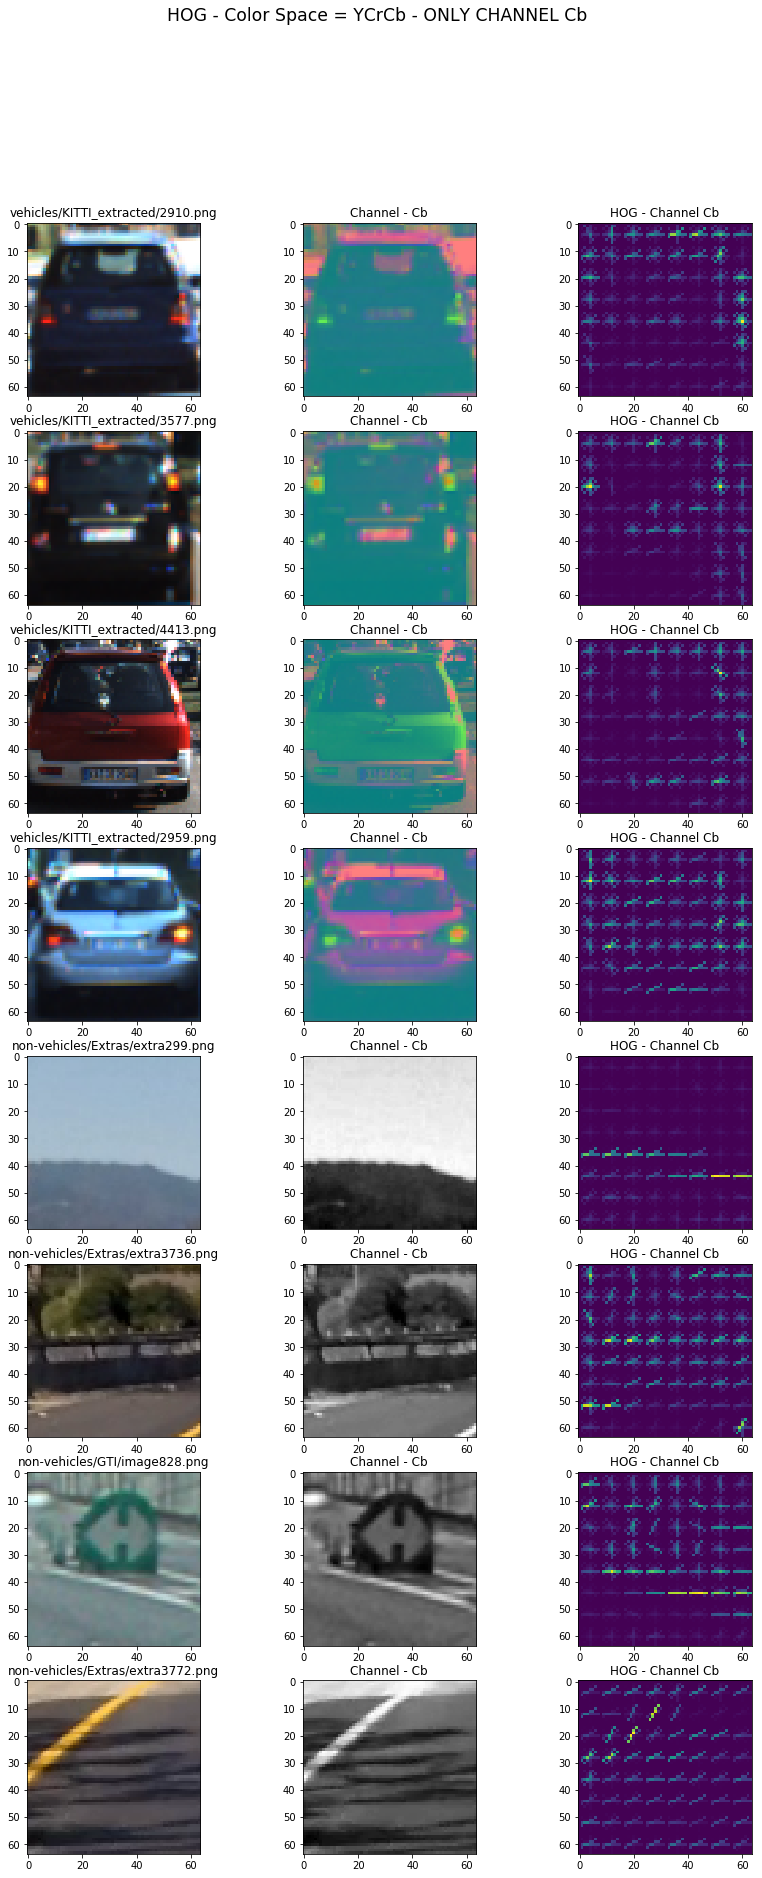

In [84]:
cars = []
images = glob.glob(PATH_VEHICLE_IMAGES+'/*/*.png')
for image in images:
    cars.append(image)

notcars = []    
images = glob.glob(PATH_NON_VEHICLE_IMAGES+'/*/*.png')
for image in images:
    notcars.append(image)

#car_features = extract_features(cars, cspace, (spatial_size, spatial_size), hist_bins, 
#                                orient, pix_per_cell, cell_per_block)
EXAMPLE_SIZE = 4
f, ax = plt.subplots(2*EXAMPLE_SIZE, 3, figsize=(14,30))

#cars_indicies = random.sample(range(0, len(cars)), EXAMPLE_SIZE)
cars_indicies = [2429, 4805, 5786, 4970]
CHANNEL = 2
CHANNEL_NAME = 'Cb'
f.suptitle('HOG - Color Space = YCrCb - ONLY CHANNEL ' + CHANNEL_NAME , fontsize='xx-large')
for i, index in enumerate(cars_indicies):
    example_car = mpimg.imread(cars[index])
    gray_example_car = cv2.cvtColor(example_car, cv2.COLOR_RGB2YCrCb)
    _, hog_example_car = get_hog_features(gray_example_car[:,:,CHANNEL], ORIENT, PIX_PER_CELLS, CELL_PER_BLOCK, vis=True, feature_vec=True)

    ax[i][0].imshow(example_car)
    ax[i][0].set_title(cars[index][16:])
    
    ax[i][1].imshow(gray_example_car, cmap='gray')
    ax[i][1].set_title("Channel - " + CHANNEL_NAME)
    
    ax[i][2].imshow(hog_example_car)
    ax[i][2].set_title("HOG - Channel " + CHANNEL_NAME )

#notcars_indicies = random.sample(range(0, len(notcars)), EXAMPLE_SIZE)
notcars_indicies = [5705, 3910, 1802, 8544]
for i, index in enumerate(notcars_indicies):    
    example_notcar = mpimg.imread(notcars[index])
    gray_example_notcar = grayscale(example_notcar)
    _, hog_example_notcar = get_hog_features(gray_example_notcar, ORIENT, PIX_PER_CELLS, CELL_PER_BLOCK, vis=True, feature_vec=True)

    ax[i+EXAMPLE_SIZE][0].imshow(example_notcar)
    ax[i+EXAMPLE_SIZE][0].set_title(notcars[index][16:])
    
    ax[i+EXAMPLE_SIZE][1].imshow(gray_example_notcar, cmap='gray')
    ax[i+EXAMPLE_SIZE][1].set_title("Channel - " + CHANNEL_NAME)
    
    ax[i+EXAMPLE_SIZE][2].imshow(hog_example_notcar)
    ax[i+EXAMPLE_SIZE][2].set_title("HOG - Channel " + CHANNEL_NAME)
    
#print(cars_indicies) # [2429, 4805, 5786, 4970]
#print(notcars_indicies) #[5705, 3910, 1802, 8544]

## Color Histogram and Spatial Bins

In [61]:
def plot_colorhistogram(color=None, title_a='R', title_b='G', title_c='B', function='color_hist'):
    f, ax = plt.subplots(2*EXAMPLE_SIZE, 4, figsize=(14,30))
    f.suptitle(function + ' - Color Space = ' + title_a + title_b + title_c , fontsize='xx-large')

    #cars_indicies = random.sample(range(0, len(cars)), EXAMPLE_SIZE)
    for i, index in enumerate(cars_indicies):
        example_car = mpimg.imread(cars[index])
        if color is not None:
            example_car_color = cv2.cvtColor(example_car, color)
        else:
            example_car_color = example_car
        
        if function == 'color_hist':
            c_hist = color_hist(example_car_color,nbins=32)
        else:
            c_hist = bin_spatial(example_car_color)
            
        color_size = (int)(c_hist.shape[0]/3)
        a = c_hist[0:color_size]
        b = c_hist[color_size:2*color_size]
        c = c_hist[2*color_size:3*color_size]
        ax[i][0].imshow(example_car)
        ax[i][0].set_title(cars[index][16:])
        
        ax[i][1].plot(a)
        ax[i][2].plot(b)
        ax[i][3].plot(c)
        
        ax[i][1].set_title(title_a)
        ax[i][2].set_title(title_b)
        ax[i][3].set_title(title_c)

    #notcars_indicies = random.sample(range(0, len(notcars)), EXAMPLE_SIZE)
    for i, index in enumerate(notcars_indicies):
        example_notcar = mpimg.imread(notcars[index])
        if color is not None:
            example_notcar_color = cv2.cvtColor(example_notcar, color)
        else:
            example_notcar_color = example_notcar
        
        if function == 'color_hist':
            c_hist = color_hist(example_notcar_color,nbins=32)
        else:
            c_hist = bin_spatial(example_notcar_color)     
        
        color_size = (int)(c_hist.shape[0]/3)
        a = c_hist[0:color_size]
        b = c_hist[color_size:2*color_size]
        c = c_hist[2*color_size:3*color_size]
        ax[i+EXAMPLE_SIZE][0].imshow(example_notcar)
        ax[i+EXAMPLE_SIZE][0].set_title(notcars[index][16:])
        
        ax[i+EXAMPLE_SIZE][1].plot(a)
        ax[i+EXAMPLE_SIZE][1].set_title(title_a)
        
        ax[i+EXAMPLE_SIZE][2].plot(b)
        ax[i+EXAMPLE_SIZE][2].set_title(title_b)
        
        ax[i+EXAMPLE_SIZE][3].plot(c)
        ax[i+EXAMPLE_SIZE][3].set_title(title_c)

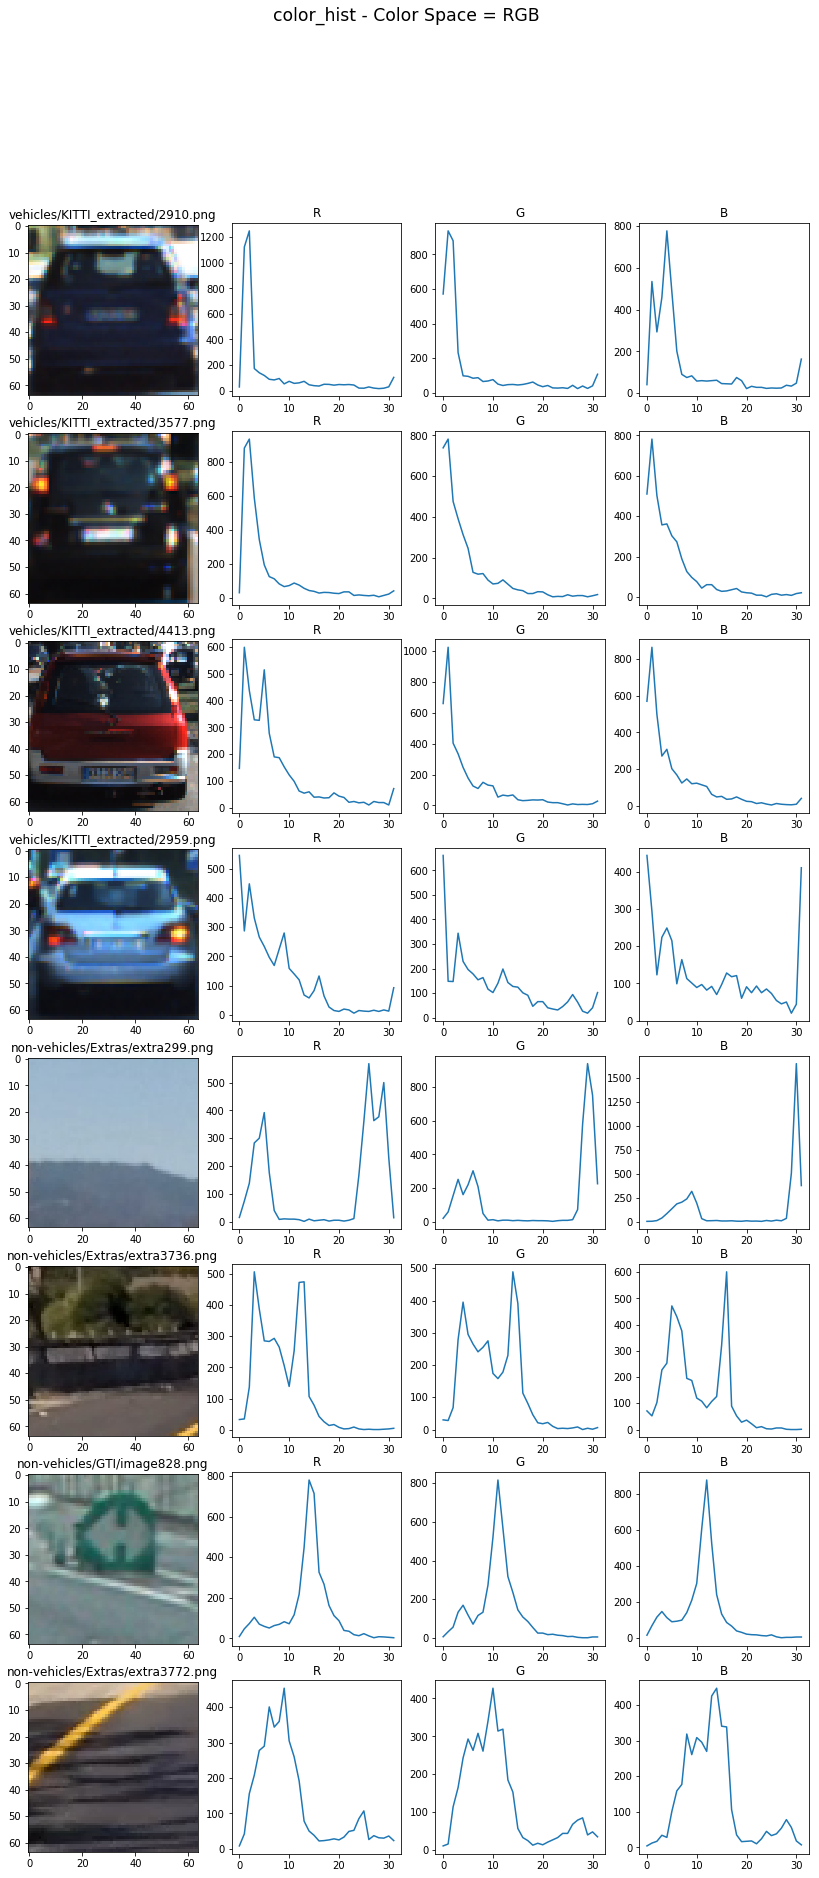

In [62]:
plot_colorhistogram(color=None, function='color_hist')

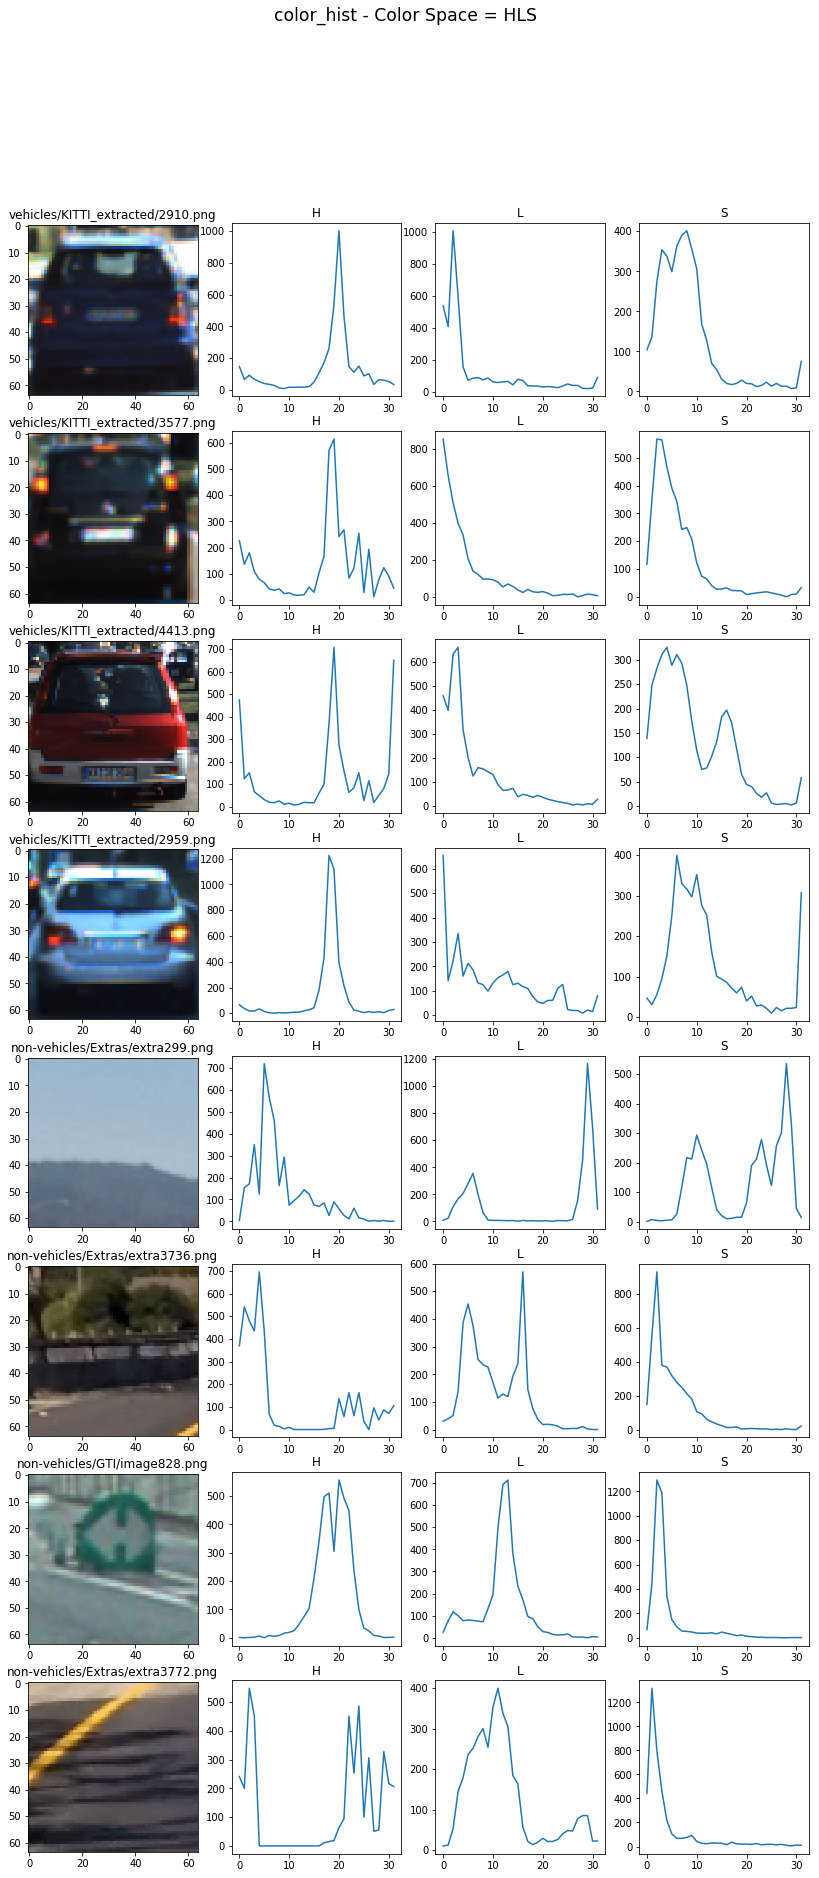

In [63]:
plot_colorhistogram(cv2.COLOR_RGB2HLS, 'H', 'L', 'S', function='color_hist')

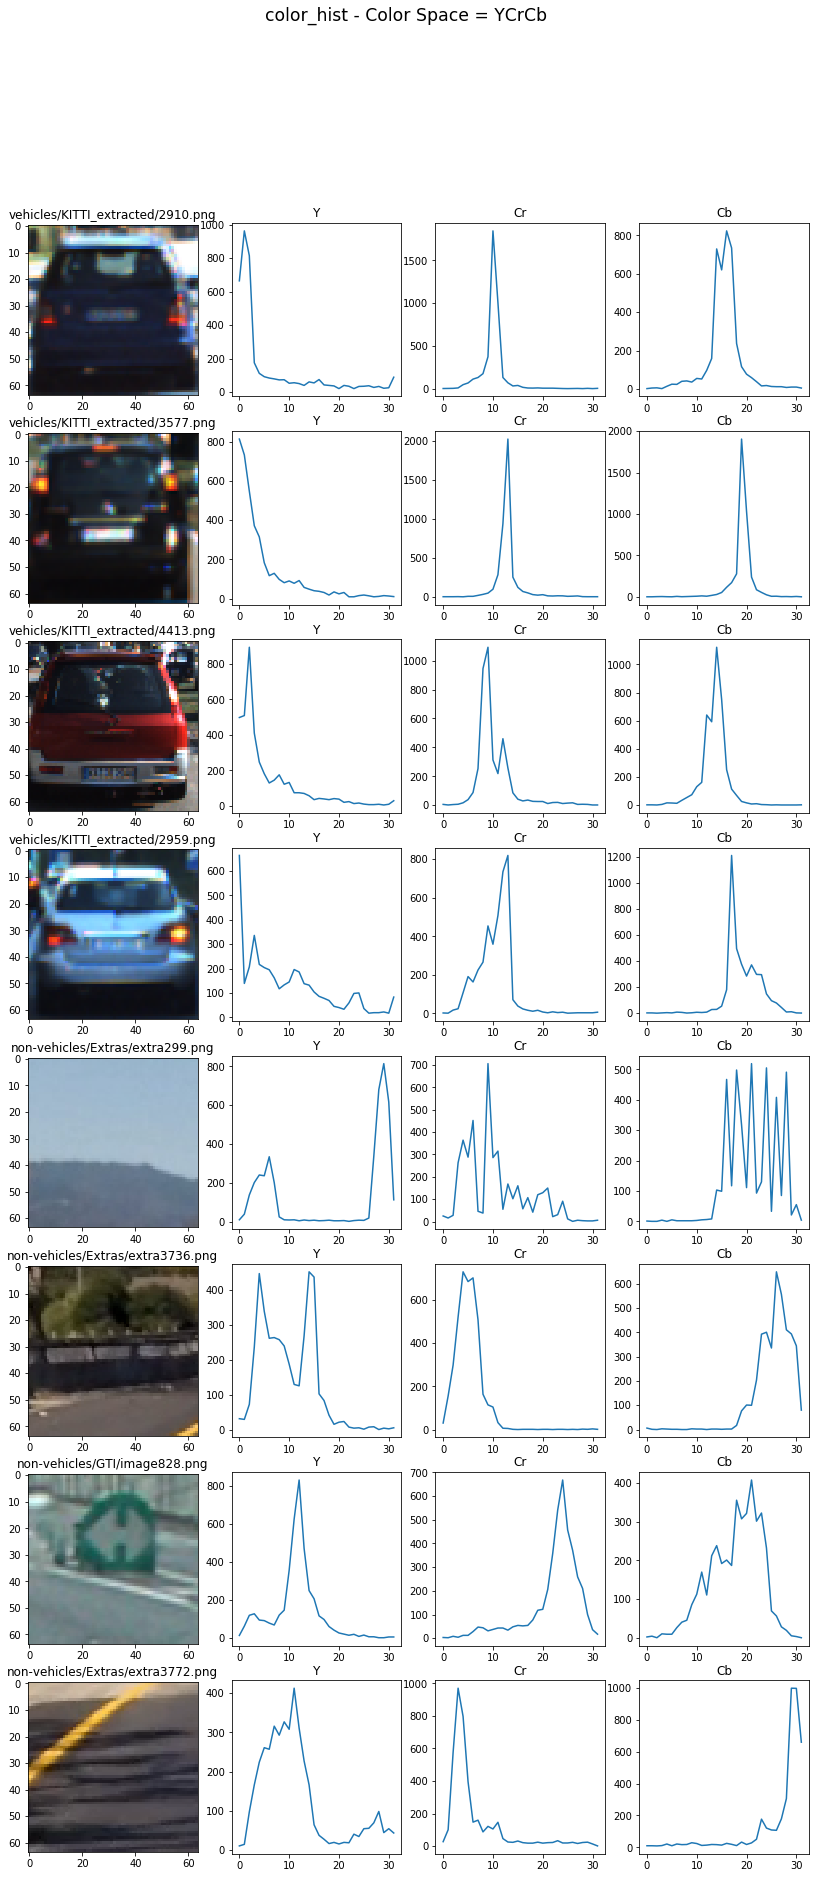

In [64]:
plot_colorhistogram(cv2.COLOR_RGB2YCrCb, 'Y', 'Cr', 'Cb', function='color_hist')

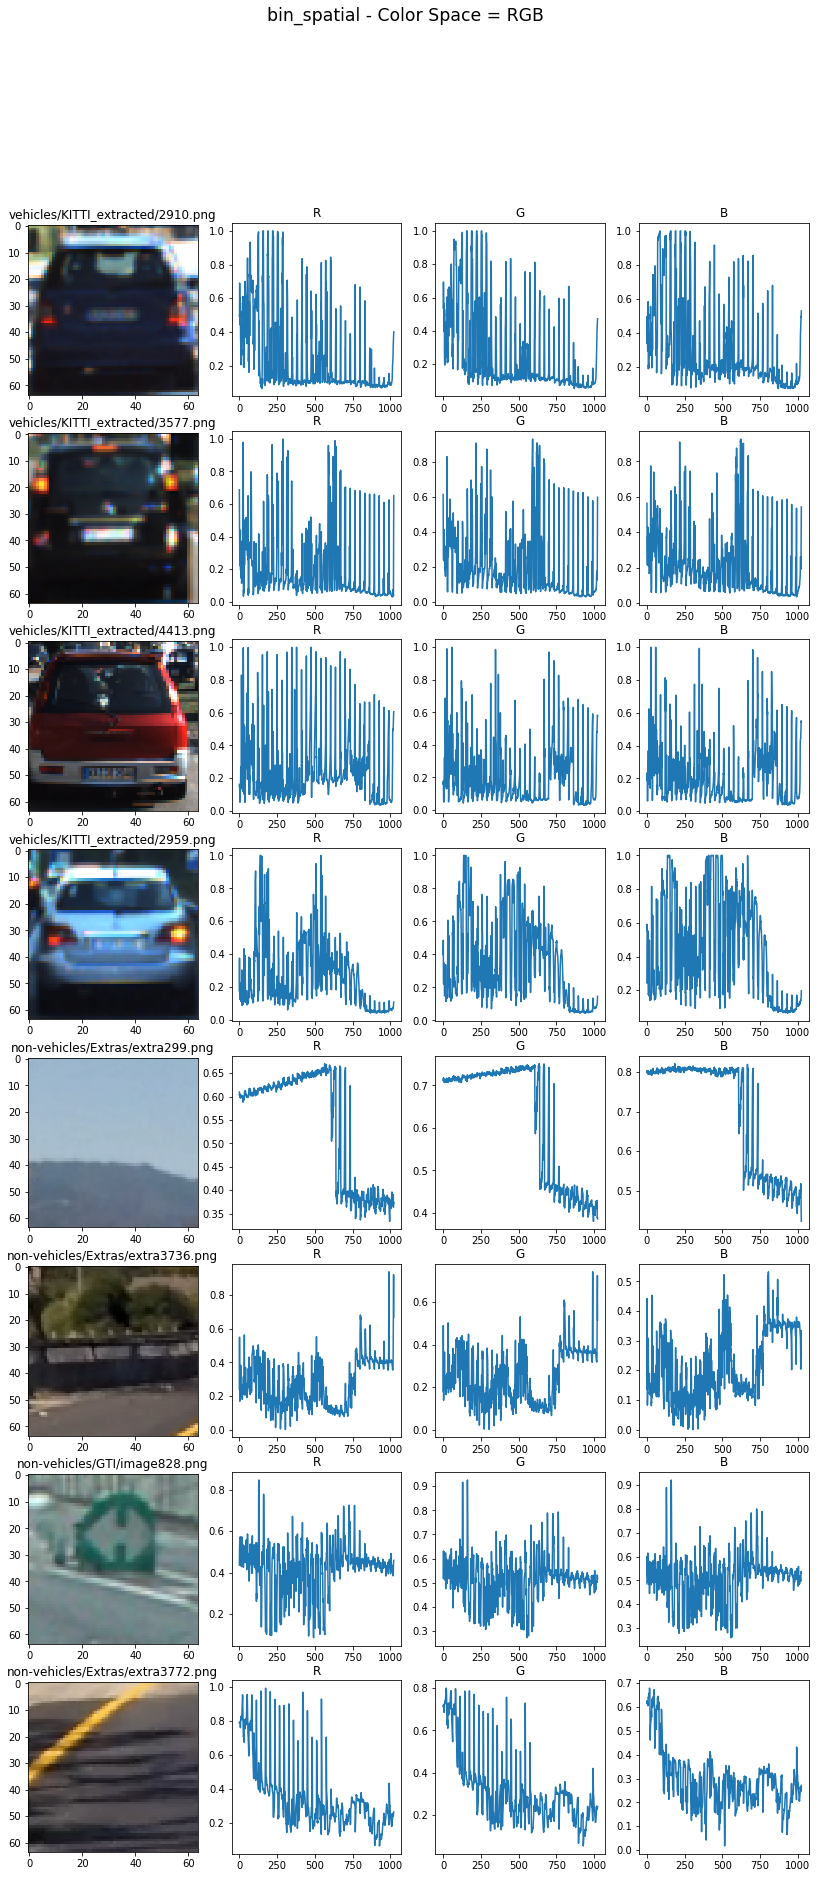

In [65]:
plot_colorhistogram(function='bin_spatial')

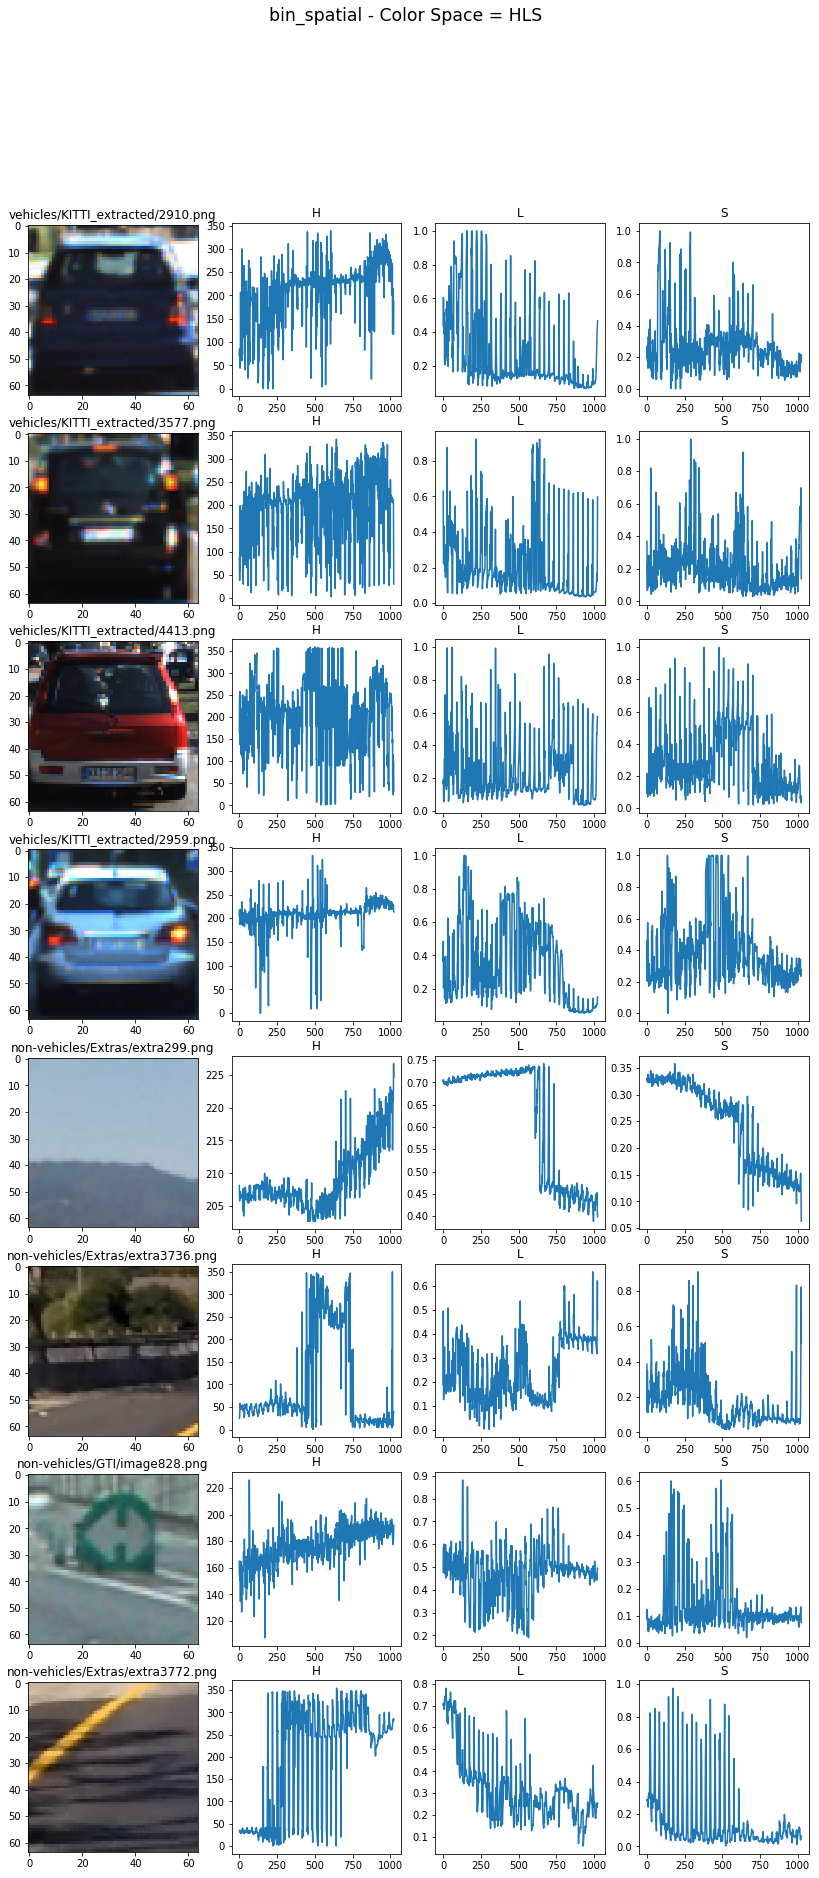

In [66]:
plot_colorhistogram(cv2.COLOR_RGB2HLS, 'H', 'L', 'S', function='bin_spatial')

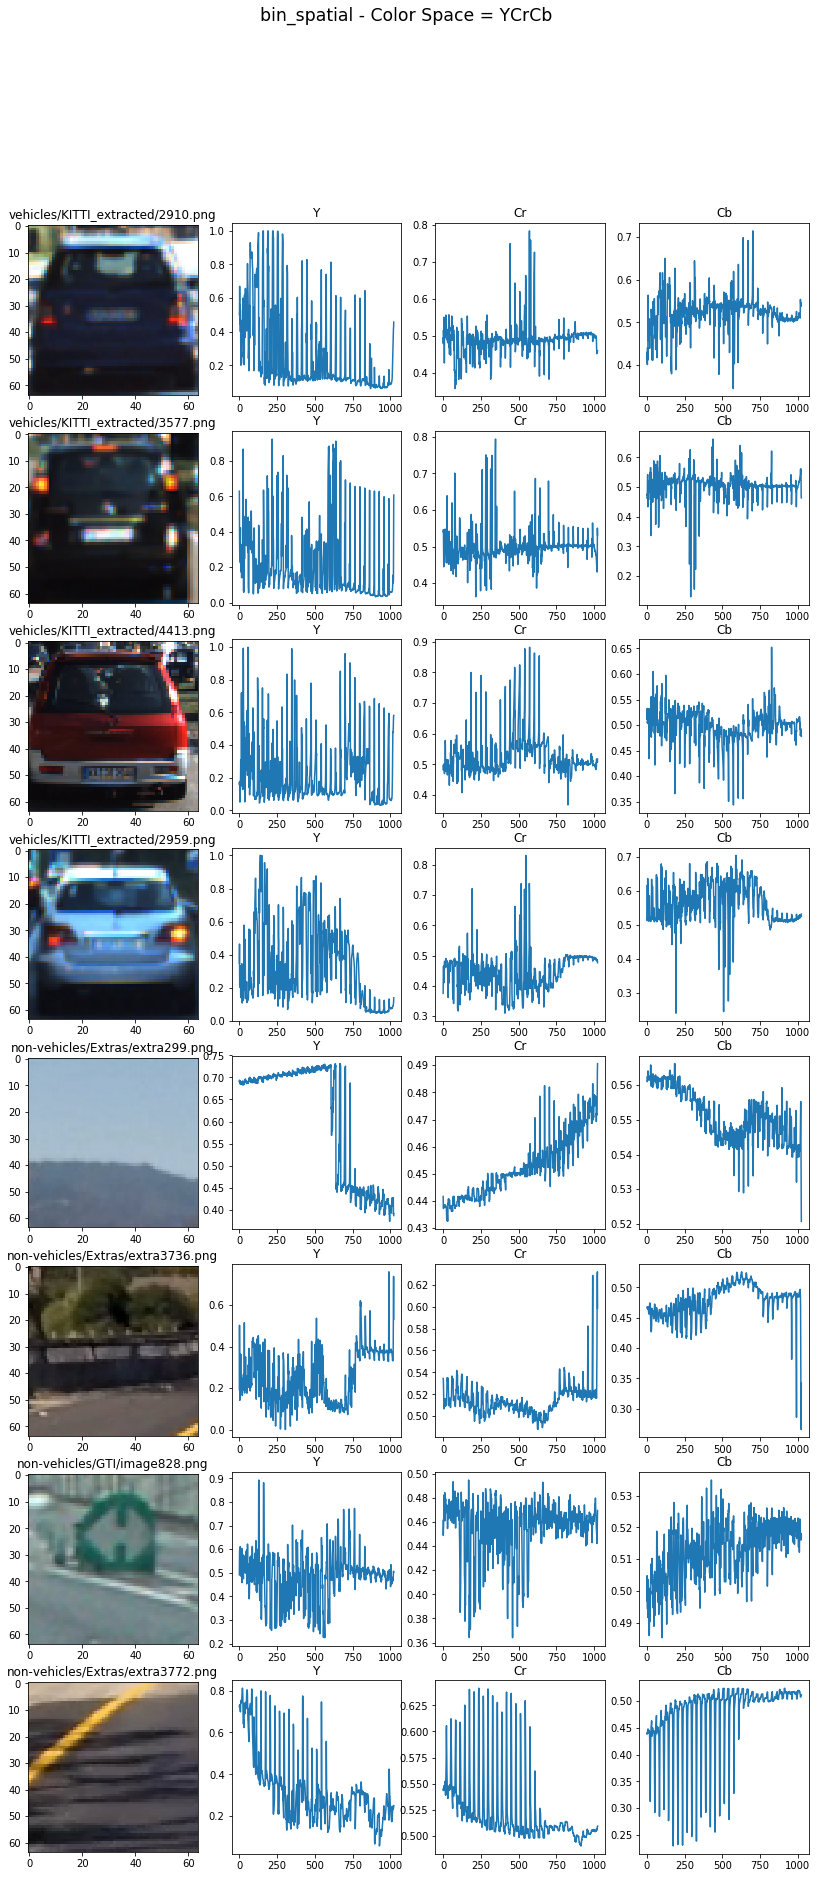

In [67]:
plot_colorhistogram(cv2.COLOR_RGB2YCrCb, 'Y', 'Cr', 'Cb', function='bin_spatial')

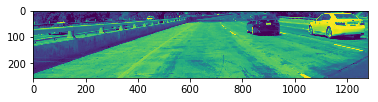

In [68]:
image = init_image('test1.jpg')
plt.imshow(image)

In [69]:
# image = read_image('test1.jpg')
# plt.imshow(image)
# image = find_cars(img=image,ystart=YSTART,ystop=YSTOP, scale=SCALE, svc=0, X_scaler=0, orient=ORIENT, 
#                   pix_per_cell=PIX_PER_CELLS,cell_per_block=CELL_PER_BLOCK, spatial_size=(SPATIAL_BIN, SPATIAL_BIN), hist_bins=HIST_BINS)

### 1.x Heatmap

In [70]:
# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import numpy as np
# import pickle
# import cv2
# from scipy.ndimage.measurements import label

# # Read in a pickle file with bboxes saved
# # Each item in the "all_bboxes" list will contain a 
# # list of boxes for one of the images shown above
# box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# # Read in image similar to one shown above 
# image = mpimg.imread('test_image.jpg')
# heat = np.zeros_like(image[:,:,0]).astype(np.float)

# def add_heat(heatmap, bbox_list):
#     # Iterate through list of bboxes
#     for box in bbox_list:
#         # Add += 1 for all pixels inside each bbox
#         # Assuming each "box" takes the form ((x1, y1), (x2, y2))
#         heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

#     # Return updated heatmap
#     return heatmap# Iterate through list of bboxes
    
# def apply_threshold(heatmap, threshold):
#     # Zero out pixels below the threshold
#     heatmap[heatmap <= threshold] = 0
#     # Return thresholded map
#     return heatmap

# def draw_labeled_bboxes(img, labels):
#     # Iterate through all detected cars
#     for car_number in range(1, labels[1]+1):
#         # Find pixels with each car_number label value
#         nonzero = (labels[0] == car_number).nonzero()
#         # Identify x and y values of those pixels
#         nonzeroy = np.array(nonzero[0])
#         nonzerox = np.array(nonzero[1])
#         # Define a bounding box based on min/max x and y
#         bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
#         # Draw the box on the image
#         cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
#     # Return the image
#     return img

# # Add heat to each box in box list
# heat = add_heat(heat,box_list)
    
# # Apply threshold to help remove false positives
# heat = apply_threshold(heat,1)

# # Visualize the heatmap when displaying    
# heatmap = np.clip(heat, 0, 255)

# # Find final boxes from heatmap using label function
# labels = label(heatmap)
# draw_img = draw_labeled_bboxes(np.copy(image), labels)

# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(draw_img)
# plt.title('Car Positions')
# plt.subplot(122)
# plt.imshow(heatmap, cmap='hot')
# plt.title('Heat Map')
# fig.tight_layout()


## SVM-Training

### SVM-Training - Read all car-filenames and noncar-filenames

### SVM-Training - Stack car and noncar, scaler, split in test_train

In [71]:
def feature_all(cspace, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, image_amout=1500):
    cars = []
    images = glob.glob(PATH_VEHICLE_IMAGES+'/*/*.png')
    for image in images:
        cars.append(image)
    
    cars = cars
    
    notcars = []    
    images = glob.glob(PATH_NON_VEHICLE_IMAGES+'/*/*.png')
    for image in images:
        notcars.append(image)
        
    notcars = notcars
    
    car_features = extract_features(cars, cspace, (spatial_size, spatial_size), hist_bins, 
                                    orient, pix_per_cell, cell_per_block)
    notcar_features = extract_features(notcars, cspace, (spatial_size, spatial_size), hist_bins, 
                                    orient, pix_per_cell, cell_per_block)
    

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.33, random_state=41)
    
    return X_train[:image_amout], X_test, y_train[:image_amout], y_test

### SVM-Training - Use SVM to train

In [72]:
X_train, X_test, y_train, y_test = feature_all('YCrCb', SPATIAL_BIN, HIST_BINS, ORIENT, PIX_PER_CELLS, CELL_PER_BLOCK)

## Normal Parameter optimisation (not Hyperparameter)

## Gridsearch for Hyperparameter

## Sliding Window Search

## Video Implementation